<a href="https://colab.research.google.com/github/alekrul/gt-health-management/blob/main/ProDiMES.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

In [4]:
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import r2_score
from scipy import stats
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix, accuracy_score, r2_score, roc_auc_score, precision_score, recall_score, f1_score

sns.set()

##Read data

In [11]:
filename = 'data.mat'

location = "/content/drive/MyDrive/Mestrado/Condition Based HM/ProDiMES/"

file_path = location + filename

In [12]:
data = loadmat(file_path)

efs_output_c = data['efs_output_c']
efs_output_to = data['efs_output_to']
engine_params = data['engine_params']
fault_params = data['fault_params']
sensor_noise = data['sensor_noise']

In [13]:
engines, flights, variables = efs_output_c.shape

efs_output_c_flat = efs_output_c.reshape(engines * flights, variables)

engine_ids = np.repeat(np.arange(1, engines + 1), flights)
flight_ids = np.tile(np.arange(1, flights + 1), engines)

column_names = ["engine", "flight"] + ["Nf_c","Nc_c","P24_c","Ps30_c","T24_c","T30_c","T48_c","Wf_c","P2_c","T2_c","Pamb_c"]
data = np.column_stack((engine_ids, flight_ids, efs_output_c_flat))
efs_output_c_df = pd.DataFrame(data, columns=column_names)

In [14]:
efs_output_c_df.head()

,engine,flight,Nf_c,Nc_c,P24_c,Ps30_c,T24_c,T30_c,T48_c,Wf_c,P2_c,T2_c,Pamb_c
0,1.0,1.0,1859.595832,7715.833535,8.037635,113.953906,500.853842,1178.331435,1465.060327,1.142543,5.139235,433.027482,3.339920
1,1.0,2.0,1810.447129,7751.359782,8.529601,115.034972,513.242330,1190.407996,1461.859352,1.137586,5.747159,451.041562,3.923802
2,1.0,3.0,1820.849278,7673.413100,7.655241,106.664922,497.614161,1165.979747,1443.481583,1.055707,5.023991,433.767442,3.417812
3,1.0,4.0,1833.791353,7641.288490,7.756760,110.829340,489.877691,1156.270536,1437.989161,1.099418,4.991406,424.458140,3.427674
4,1.0,5.0,1830.194811,7649.170919,7.938302,111.945776,492.987600,1159.236156,1437.390716,1.106730,5.138531,427.878730,3.443684


In [15]:
engines, flights, variables = efs_output_to.shape

efs_output_to_flat = efs_output_to.reshape(engines * flights, variables)

engine_ids = np.repeat(np.arange(1, engines + 1), flights)
flight_ids = np.tile(np.arange(1, flights + 1), engines)

column_names = ["engine", "flight"] + ["Nf_to","Nc_to","P24_to","Ps30_to","T24_to","T30_to","T48_to","Wf_to","P2_to","T2_to","Pamb_to"]
data = np.column_stack((engine_ids, flight_ids, efs_output_to_flat))
efs_output_to_df = pd.DataFrame(data, columns=column_names)

In [16]:
efs_output_to_df.head()

,engine,flight,Nf_to,Nc_to,P24_to,Ps30_to,T24_to,T30_to,T48_to,Wf_to,P2_to,T2_to,Pamb_to
0,1.0,1.0,2339.271150,9045.702711,27.306823,477.686281,650.431031,1593.794706,2112.627387,6.401851,14.775466,532.445661,14.300201
1,1.0,2.0,2413.507949,9142.554805,24.424444,438.554748,658.386937,1624.018085,2174.999886,6.043534,12.641754,531.430147,12.182256
2,1.0,3.0,2371.600299,9182.835564,27.313581,476.874091,670.662587,1637.445975,2175.000255,6.524660,14.818824,549.451189,14.354735
3,1.0,4.0,2399.100305,9155.317170,24.016622,426.993045,662.338715,1628.054256,2174.999800,5.871794,12.636289,537.449542,12.166091
4,1.0,5.0,2331.950449,9017.499406,27.380540,479.045321,646.365264,1584.872687,2099.762407,6.391934,14.815391,529.118320,14.340751


In [17]:
engines, flights, params = engine_params.shape

engine_params_flat = engine_params.reshape(engines * flights, params)

engine_params_columns = ["engine", "flight","altitude_to","mach_to","dTamb_to","NfR_to","altitude_c","mach_c",
                         "dTamb_c","Fn_c","fan_eff","fan_fc","lpc_eff","lpc_fc","hpc_eff","hpc_fc",
                         "hpt_eff","hpt_fc","lpt_eff","lpt_fc"]

engine_ids = np.repeat(np.arange(1, engines + 1), flights)
flight_ids = np.tile(np.arange(1, flights + 1), engines)

data = np.column_stack((engine_ids, flight_ids, engine_params_flat))
engine_params_df = pd.DataFrame(data, columns=engine_params_columns)

In [18]:
engine_params_df.head()

,engine,flight,altitude_to,mach_to,dTamb_to,NfR_to,altitude_c,mach_c,dTamb_c,Fn_c,fan_eff,fan_fc,lpc_eff,lpc_fc,hpc_eff,hpc_fc,hpt_eff,hpt_fc,lpt_eff,lpt_fc
0,1.0,1.0,753.542747,0.226406,11.059727,2339.271150,35727.931768,0.811416,-8.616973,6475.757322,-1.521502,-1.031776,-0.608823,-0.983948,-1.944067,-2.229537,-0.818469,0.480494,0.021486,0.092161
1,1.0,2.0,5099.630838,0.239818,24.902952,2417.195916,32312.660182,0.761073,0.776824,6147.686476,-1.521887,-1.032272,-0.609011,-0.984416,-1.944421,-2.230300,-0.818723,0.480665,0.021445,0.092181
2,1.0,3.0,648.722908,0.223596,27.655032,2376.333974,35245.636378,0.764815,-4.641804,6011.885897,-1.522272,-1.032767,-0.609200,-0.984884,-1.944775,-2.231064,-0.818977,0.480837,0.021404,0.092201
3,1.0,4.0,5135.081578,0.242501,30.844399,2430.846897,35185.213054,0.754971,-12.170908,6556.597869,-1.522658,-1.033263,-0.609389,-0.985352,-1.945129,-2.231830,-0.819231,0.481008,0.021363,0.092221
4,1.0,5.0,675.570560,0.225981,7.508015,2331.950449,35087.411483,0.780340,-12.116359,6385.635817,-1.523043,-1.033758,-0.609578,-0.985820,-1.945483,-2.232596,-0.819485,0.481179,0.021321,0.092241


In [19]:
fault_params_df = pd.DataFrame(fault_params, columns=["fault_id","fligh_initiation","fault_ev_rate","fault_magnitude","fc_eff_ratio"])

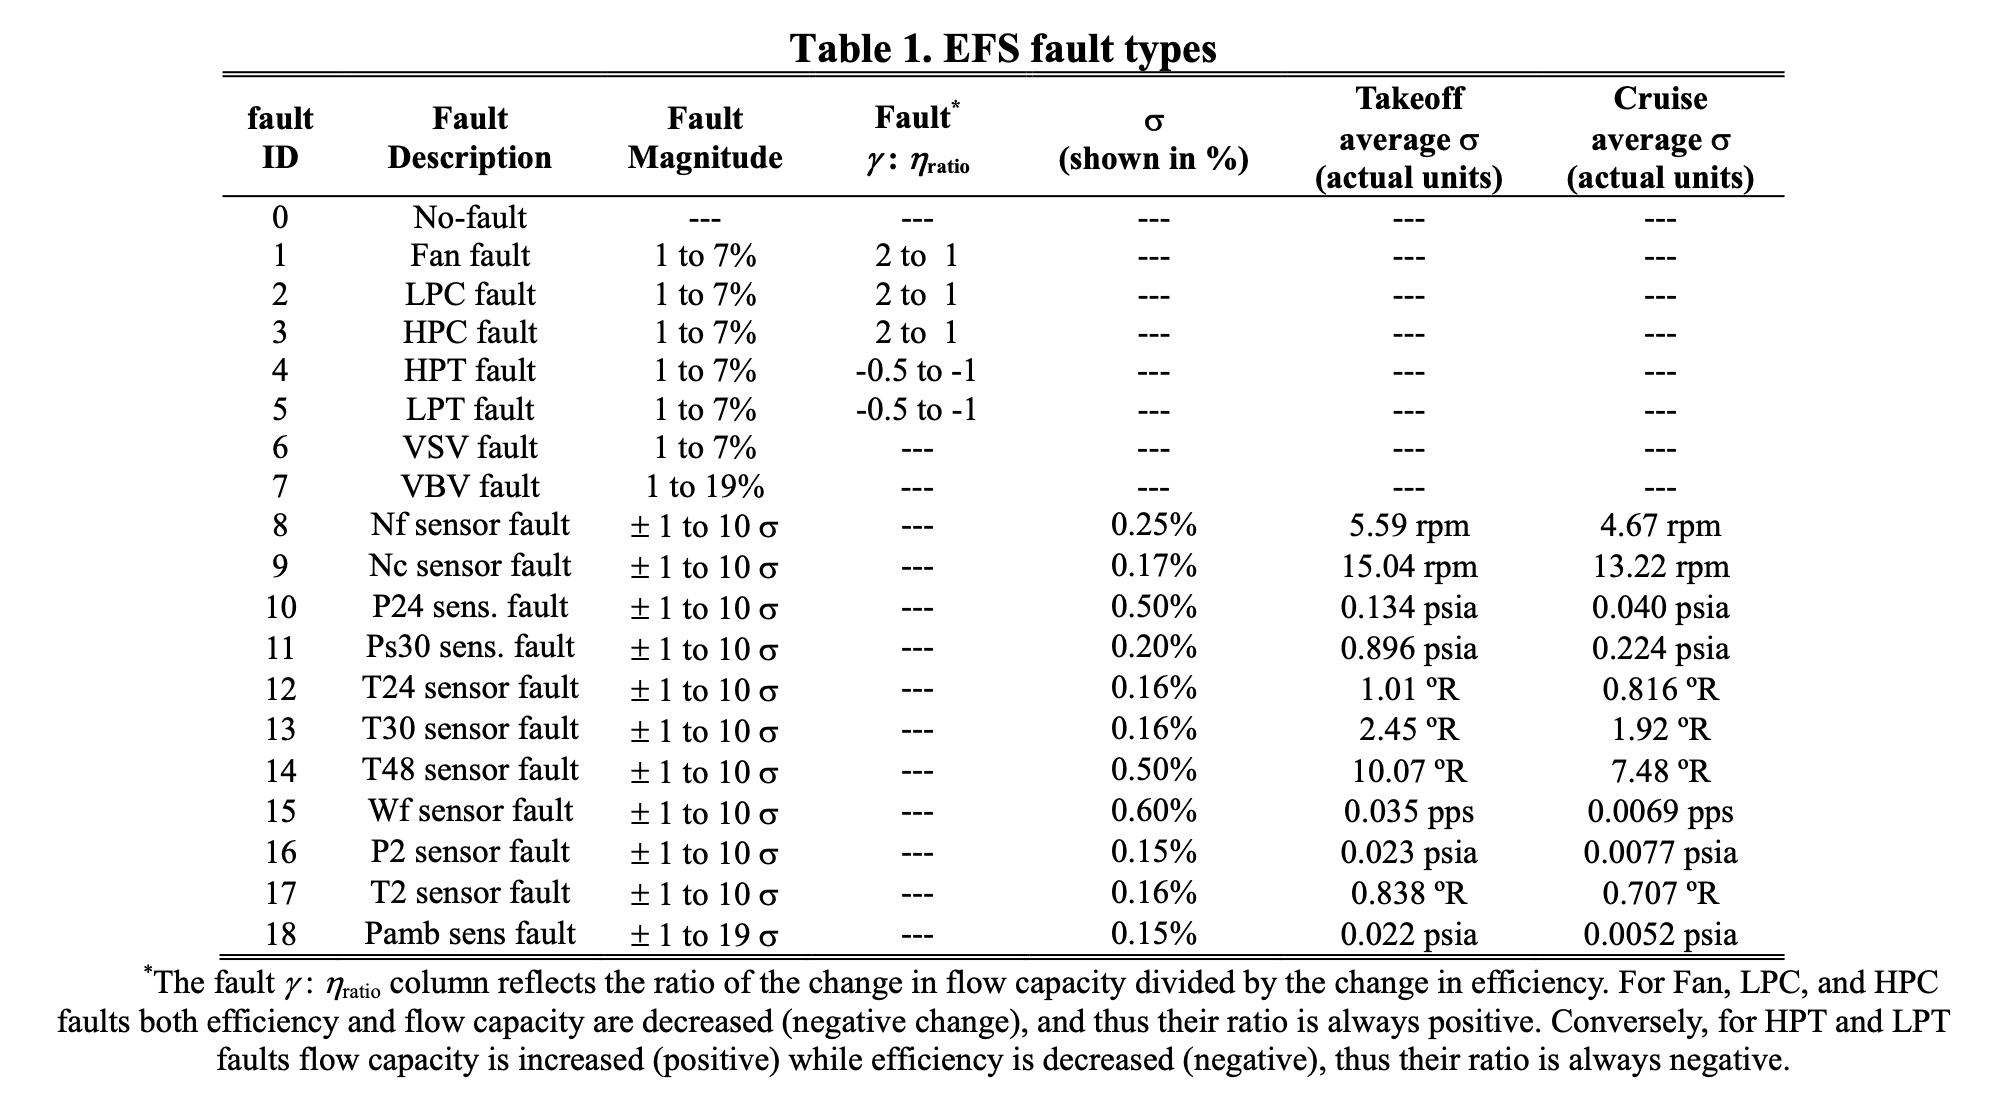

In [20]:
fault_params_df = fault_params_df.rename_axis("engine")

In [21]:
fault_params_df.head()

,fault_id,fligh_initiation,fault_ev_rate,fault_magnitude,fc_eff_ratio
engine,,,,,
0,0.0,1.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0


## Visualize Data

In [22]:
def visualize_param(dataset,engine, ysensor,xsensor):
  y_values = dataset[dataset['engine'] == engine][[ysensor]]
  x_values = dataset[dataset['engine'] == engine][[xsensor]]

  plt.figure(figsize=(8, 6))  # Set the figure size
  plt.plot(x_values, y_values, marker='o', linestyle='-', color='b', label=y_values.columns[0]+' vs. '+x_values.columns[0])
  plt.xlabel(x_values.columns[0])
  plt.ylabel(y_values.columns[0])
  plt.title(label=y_values.columns[0]+' vs. '+x_values.columns[0])
  plt.legend()
  plt.grid(True)

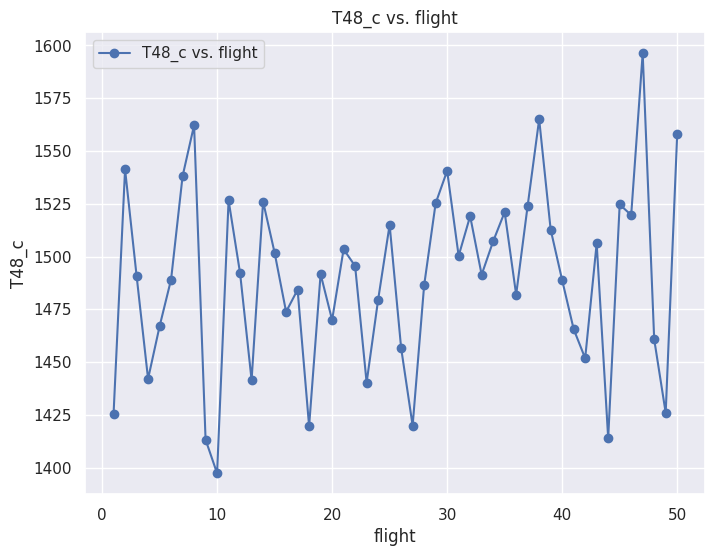

In [23]:
visualize_param(efs_output_c_df,88,"T48_c","flight")

In [24]:
def scatter_values(dataset, engines, ysensor, xsensor, fault_df=fault_params_df):
    fault_df = fault_df.reset_index()

    subset = dataset[dataset['engine'].isin(engines)]

    subset = subset.merge(fault_df[['engine', 'fault_id']], on='engine', how='left')

    fault_ids = subset['fault_id'].unique()
    colors = plt.cm.tab10(range(len(fault_ids)))
    fault_colors = {fault_id: colors[i] for i, fault_id in enumerate(fault_ids)}

    plt.figure(figsize=(10, 7))
    for fault_id, color in fault_colors.items():
        fault_subset = subset[subset['fault_id'] == fault_id]
        plt.scatter(
            fault_subset[xsensor], fault_subset[ysensor],
            color=color, label=f'Fault ID {fault_id}', alpha=0.8
        )

    plt.xlabel(xsensor)
    plt.ylabel(ysensor)
    plt.title(f'{ysensor} vs. {xsensor} by Fault Type')
    plt.legend()
    plt.grid(True)
    plt.show()

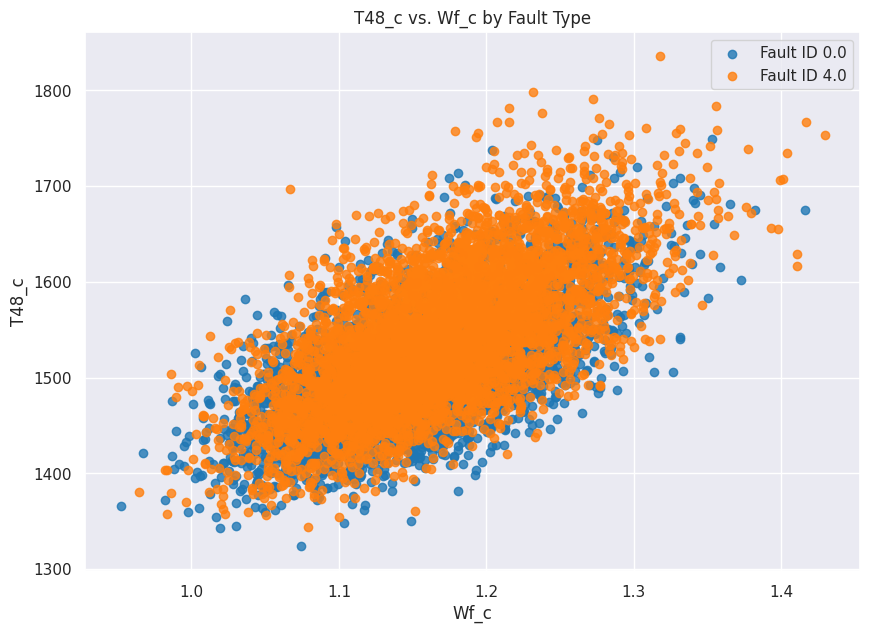

In [25]:
faults = [0,4]
engines = fault_params_df[fault_params_df["fault_id"].isin(faults)].index

scatter_values(efs_output_c_df,engines,"T48_c","Wf_c",fault_params_df)

##Data pre-processing

###Baseline

Tentar de dois jeitos:
1. interpolação com dados gerados pelo CMAPSS-SS
2. Rede Neural que faz a estimativa

1. Interpolação com dados gerados pelo CMAPSS-SS

In [26]:
file1 = 'EFS_fault_conditions_health.mat'
file2 = 'EFS_operating_conditions_health.mat'
file3 = 'EFS_Output_health.mat'

location = "/content/drive/MyDrive/Mestrado/Condition Based HM/ProDiMES/"

file_path1 = location + file1
file_path2 = location + file2
file_path3 = location + file3

data1 = loadmat(file_path1)
data2 = loadmat(file_path2)
data3 = loadmat(file_path3)

health_efs_output_c = data3['efs_output_c']
health_efs_output_to = data3['efs_output_to']
health_engine_params = data2['engine_params']
health_fault_params = data1['fault_params']
health_sensor_noise = data2['sensor_noise']

In [27]:
health_efs_output_c.shape

(100, 90, 11)

In [28]:
engines, flights, variables = health_efs_output_c.shape

health_efs_output_c_flat = health_efs_output_c.reshape(engines * flights, variables)

engine_ids = np.repeat(np.arange(1, engines + 1), flights)
flight_ids = np.tile(np.arange(1, flights + 1), engines)

column_names = ["engine", "flight"] + ["Nf_c","Nc_c","P24_c","Ps30_c","T24_c","T30_c","T48_c","Wf_c","P2_c","T2_c","Pamb_c"]
data = np.column_stack((engine_ids, flight_ids, health_efs_output_c_flat))
health_efs_output_c_df = pd.DataFrame(data, columns=column_names)

In [29]:
engines, flights, variables = health_efs_output_to.shape

health_efs_output_to_flat = health_efs_output_to.reshape(engines * flights, variables)

engine_ids = np.repeat(np.arange(1, engines + 1), flights)
flight_ids = np.tile(np.arange(1, flights + 1), engines)

column_names = ["engine", "flight"] + ["Nf_to","Nc_to","P24_to","Ps30_to","T24_to","T30_to","T48_to","Wf_to","P2_to","T2_to","Pamb_to"]
data = np.column_stack((engine_ids, flight_ids, health_efs_output_to_flat))
health_efs_output_to_df = pd.DataFrame(data, columns=column_names)

In [30]:
engines, flights, params = health_engine_params.shape

health_engine_params_flat = health_engine_params.reshape(engines * flights, params)

health_engine_params_columns = ["engine", "flight","altitude_to","mach_to","dTamb_to","NfR_to","altitude_c","mach_c",
                         "dTamb_c","Fn_c","fan_eff","fan_fc","lpc_eff","lpc_fc","hpc_eff","hpc_fc",
                         "hpt_eff","hpt_fc","lpt_eff","lpt_fc"]

engine_ids = np.repeat(np.arange(1, engines + 1), flights)
flight_ids = np.tile(np.arange(1, flights + 1), engines)

data = np.column_stack((engine_ids, flight_ids, health_engine_params_flat))
health_engine_params_df = pd.DataFrame(data, columns=health_engine_params_columns)

In [31]:
u_to = health_engine_params_df[["altitude_to","mach_to","dTamb_to","NfR_to"]]
u_c = health_engine_params_df[["altitude_c","mach_c","dTamb_c","Fn_c"]]

In [32]:
y_to = health_efs_output_to_df.drop(columns=["engine","flight"])
y_c =  health_efs_output_c_df.drop(columns=["engine","flight"])

In [33]:
y_to.head()

,Nf_to,Nc_to,P24_to,Ps30_to,T24_to,T30_to,T48_to,Wf_to,P2_to,T2_to,Pamb_to
0,2192.553081,8764.962719,26.272345,422.263273,608.549299,1527.072893,2065.990727,5.712490,14.816205,504.008808,14.311442
1,2285.351732,8961.558306,26.910034,442.930156,631.192006,1590.269974,2175.000904,6.251980,14.592050,515.989674,14.131321
2,2157.871399,8631.145306,26.231978,422.830648,589.515879,1484.714016,2004.436747,5.599660,14.794735,488.190149,14.353818
3,2279.530225,8896.933909,27.332680,453.226359,620.582363,1569.644310,2148.169670,6.349092,14.669274,505.597448,14.216008
4,2195.911004,8780.272071,26.295601,422.932312,610.493531,1531.997975,2073.785761,5.738334,14.827145,505.553782,14.363081


In [64]:
models_to = {}
polynomial_features = PolynomialFeatures(degree=2, include_bias=False)

for column in y_to.columns:
    pipeline = Pipeline([
        ("poly_features", PolynomialFeatures(degree=2, include_bias=False)),
        ("lin_reg", LinearRegression())
    ])

    pipeline.fit(u_to, y_to[column])

    models_to[column] = pipeline


In [65]:
models_c = {}
polynomial_features = PolynomialFeatures(degree=2, include_bias=False)

for column in y_c.columns:
    pipeline = Pipeline([
        ("poly_features", PolynomialFeatures(degree=2, include_bias=False)),
        ("lin_reg", LinearRegression())
    ])

    pipeline.fit(u_c, y_c[column])

    models_c[column] = pipeline

In [66]:
#estimating the parameters from the health dataset to evaluate model

health_y_to_model = {}
for column, model in models_to.items():
    health_y_to_model[column] = model.predict(u_to)

health_y_c_model = {}
for column, model in models_c.items():
    health_y_c_model[column] = model.predict(u_c)

health_y_to_model_df = pd.DataFrame(health_y_to_model)
health_y_c_model_df = pd.DataFrame(health_y_c_model)

In [67]:
#now estimate for the parameters of the original dataset
u_orig_to = engine_params_df[["altitude_to","mach_to","dTamb_to","NfR_to"]]
u_orig_c = engine_params_df[["altitude_c","mach_c","dTamb_c","Fn_c"]]

health_y_to = {}
for column, model in models_to.items():
    health_y_to[column] = model.predict(u_orig_to)

health_y_c = {}
for column, model in models_c.items():
    health_y_c[column] = model.predict(u_orig_c)

health_y_to_df = pd.DataFrame(health_y_to)
health_y_c_df = pd.DataFrame(health_y_c)

In [68]:
health_y_to_df.head()

,Nf_to,Nc_to,P24_to,Ps30_to,T24_to,T30_to,T48_to,Wf_to,P2_to,T2_to,Pamb_to
0,2333.339161,9036.437033,27.290385,469.998261,650.200891,1593.389173,2119.971051,6.339569,14.775508,532.445766,14.300242
1,2382.677301,9097.843414,24.062990,423.933270,654.837601,1610.749785,2150.252727,5.781446,12.641624,531.430208,12.182149
2,2345.057997,9140.515678,27.004860,461.246866,667.737601,1625.598708,2159.563980,6.290000,14.818883,549.451424,14.354787
3,2383.172719,9131.204923,23.874291,418.264346,660.655465,1621.335528,2163.550255,5.726383,12.636185,537.449494,12.166014
4,2329.039201,9013.301560,27.408565,472.467571,646.536602,1586.166225,2110.569776,6.355447,14.815439,529.118362,14.340797


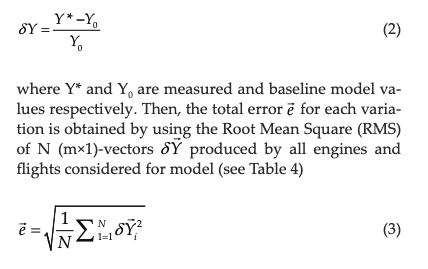

In [71]:
def calculate_rmse(y_true, y_pred):
    return np.sqrt(np.mean(((y_true - y_pred)/y_pred) ** 2))

rmse_to = {col: calculate_rmse(y_to[col].values, health_y_to_model_df[col].values) for col in y_to.columns}
rmse_to["Mean"] = np.mean(list(rmse_to.values()))

rmse_c = {col: calculate_rmse(y_c[col].values, health_y_c_model_df[col].values) for col in y_c.columns}
rmse_c["Mean"] = np.mean(list(rmse_c.values()))

rmse_df = pd.DataFrame([rmse_to, rmse_c], index=["Takeoff Model", "Cruise Model"])

In [72]:
rmse_df.head()

,Nf_to,Nc_to,P24_to,Ps30_to,T24_to,T30_to,T48_to,Wf_to,P2_to,T2_to,...,Nc_c,P24_c,Ps30_c,T24_c,T30_c,T48_c,Wf_c,P2_c,T2_c,Pamb_c
Takeoff Model,0.011131,0.004072,0.01366,0.032124,0.004162,0.008835,0.020497,0.028334,0.000005,5.690405e-07,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Cruise Model,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.003741,0.002914,0.010796,0.002668,0.010763,0.026842,0.022631,0.000122,0.001562,0.000053


In [75]:
# Separar colunas que terminam com '_to'
rmse_to_df = rmse_df[[col for col in rmse_df.columns if '_to' in col] + ['Mean']]

# Separar colunas que terminam com '_c'
rmse_c_df = rmse_df[[col for col in rmse_df.columns if '_c' in col] + ['Mean']]

# Exibir os DataFrames separados
print("### RMSE Takeoff Model ###")
print(rmse_to_df.to_string())

print("\n### RMSE Cruise Model ###")
print(rmse_c_df.to_string())

### RMSE Takeoff Model ###
                  Nf_to     Nc_to   P24_to   Ps30_to    T24_to    T30_to    T48_to     Wf_to     P2_to         T2_to   Pamb_to      Mean
Takeoff Model  0.011131  0.004072  0.01366  0.032124  0.004162  0.008835  0.020497  0.028334  0.000005  5.690405e-07  0.000005  0.011166
Cruise Model        NaN       NaN      NaN       NaN       NaN       NaN       NaN       NaN       NaN           NaN       NaN  0.007798

### RMSE Cruise Model ###
                   Nf_c      Nc_c     P24_c    Ps30_c     T24_c     T30_c     T48_c      Wf_c      P2_c      T2_c    Pamb_c      Mean
Takeoff Model       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN  0.011166
Cruise Model   0.003687  0.003741  0.002914  0.010796  0.002668  0.010763  0.026842  0.022631  0.000122  0.001562  0.000053  0.007798


In [77]:
deviation_to = {}
for column in efs_output_to_df.columns[2:]:
  deviation_to[column] = (efs_output_to_df[column] - health_y_to_df[column])/health_y_to_df[column]

deviation_c = {}
for column in efs_output_c_df.columns[2:]:
  deviation_c[column] = (efs_output_c_df[column] - health_y_c_df[column])/health_y_c_df[column]


deviation_to_df = pd.DataFrame(deviation_to)
deviation_c_df = pd.DataFrame(deviation_c)

In [78]:
deviation_c_df["engine"] = efs_output_c_df["engine"]
deviation_c_df["flight"] = efs_output_c_df["flight"]

In [79]:
deviation_to_df["engine"] = efs_output_to_df["engine"]
deviation_to_df["flight"] = efs_output_to_df["flight"]

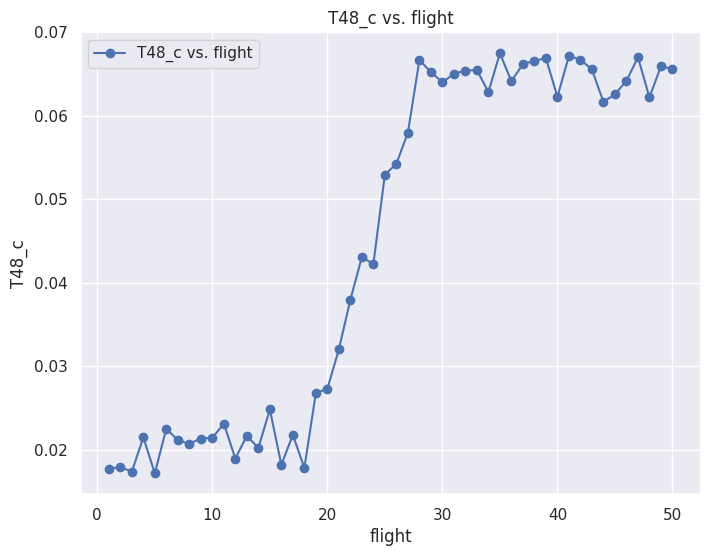

In [80]:
visualize_param(deviation_c_df,442,"T48_c","flight")

In [81]:
#note that for first 10 flights (health engine) deviation is higher than 0.
#Next step is to adjust the general model to consider specific engine characteristics

#first 10 flights are healthy conditions
def calculate_average_deviation(deviation_df):
    average_deviation = (
        deviation_df.groupby('engine')
        .apply(lambda group: group.iloc[:10, :-2].mean())
        .reset_index()
    )
    return average_deviation

average_deviation_to_df = calculate_average_deviation(deviation_to_df)
average_deviation_c_df = calculate_average_deviation(deviation_c_df)

<ipython-input-81-e4d2687681d1>:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda group: group.iloc[:10, :-2].mean())
<ipython-input-81-e4d2687681d1>:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda group: group.iloc[:10, :-2].mean())


In [82]:
average_deviation_c_df.head()

,engine,Nf_c,Nc_c,P24_c,Ps30_c,T24_c,T30_c,T48_c,Wf_c,P2_c,T2_c,Pamb_c
0,1.0,-0.002920,-0.001158,-0.003752,0.006776,-0.001425,-0.003983,-0.010779,-0.007415,0.000024,0.000087,0.000018
1,2.0,0.001153,0.002728,-0.000984,-0.012053,0.001419,0.006992,0.024352,0.022919,-0.000043,0.000292,-0.000010
2,3.0,0.000083,-0.000658,0.000192,-0.000258,0.000569,-0.002584,-0.002422,-0.001426,0.000029,0.000309,0.000011
3,4.0,-0.000006,-0.001670,0.001540,-0.003295,0.000858,-0.003175,0.000917,0.000149,-0.000098,0.000245,-0.000032
4,5.0,-0.001619,-0.002429,-0.001167,0.005777,-0.001229,-0.007447,-0.016992,-0.015980,0.000032,0.000234,0.000006


In [83]:
health_y_c_df["flight"] = efs_output_c_df["flight"]
health_y_c_df["engine"] = efs_output_c_df["engine"]

health_y_to_df["flight"] = efs_output_to_df["flight"]
health_y_to_df["engine"] = efs_output_to_df["engine"]

In [84]:
def update_health_conditions(health_y_df, avg_deviation_df, deviation_columns):
    updated_health_y_df = health_y_df.copy()

    for engine in avg_deviation_df['engine']:

        engine_avg_deviation = avg_deviation_df[avg_deviation_df['engine'] == engine][deviation_columns].iloc[0]

        engine_mask = (health_y_df['engine'] == engine)
        for column in deviation_columns:
            updated_health_y_df.loc[engine_mask, column] *= (1 + engine_avg_deviation[column])

    return updated_health_y_df

updated_health_y_to_df = update_health_conditions(health_y_to_df, average_deviation_to_df, health_y_to_df.drop(columns=["engine","flight"]).columns)
updated_health_y_c_df = update_health_conditions(health_y_c_df, average_deviation_c_df, health_y_c_df.drop(columns=["engine","flight"]).columns)

In [85]:
updated_health_y_to_df.head()

,Nf_to,Nc_to,P24_to,Ps30_to,T24_to,T30_to,T48_to,Wf_to,P2_to,T2_to,Pamb_to,flight,engine
0,2346.116394,9054.477660,27.410289,479.734887,651.351899,1597.139402,2121.769625,6.462371,14.775532,532.445684,14.300252,1.0,1.0
1,2395.724706,9116.006634,24.168714,432.715600,655.996816,1614.540875,2152.076992,5.893437,12.641645,531.430126,12.182158,2.0,1.0
2,2357.899401,9158.764091,27.123510,470.802195,668.919653,1629.424746,2161.396144,6.411841,14.818908,549.451340,14.354797,3.0,1.0
3,2396.222837,9149.434748,23.979186,426.929236,661.824979,1625.151533,2165.385801,5.837307,12.636206,537.449412,12.166023,4.0,1.0
4,2341.792887,9031.295998,27.528987,482.255352,647.681123,1589.899454,2112.360374,6.478557,14.815463,529.118281,14.340807,5.0,1.0


In [86]:
def calculate_final_deviations(observed_df, updated_health_y_df, deviation_columns):
    final_deviation_df = pd.DataFrame()
    for column in deviation_columns:
        final_deviation_df[column] = (observed_df[column] - updated_health_y_df[column]) / updated_health_y_df[column]
    return final_deviation_df

final_deviation_to_df = calculate_final_deviations(efs_output_to_df, updated_health_y_to_df, health_y_to_df.drop(columns=["engine","flight"]).columns)
final_deviation_c_df = calculate_final_deviations(efs_output_c_df, updated_health_y_c_df, health_y_c_df.drop(columns=["engine","flight"]).columns)


In [87]:
final_deviation_to_df["engine"] = efs_output_to_df["engine"]
final_deviation_to_df["flight"] = efs_output_to_df["flight"]

final_deviation_c_df["engine"] = efs_output_c_df["engine"]
final_deviation_c_df["flight"] = efs_output_c_df["flight"]

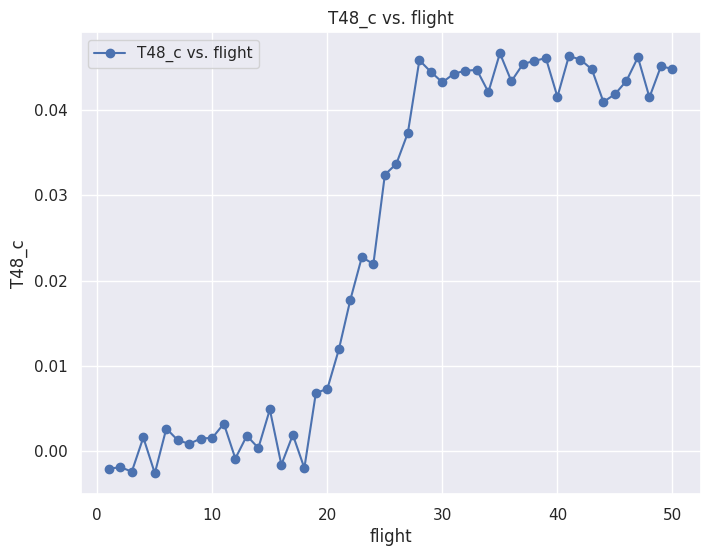

In [88]:
visualize_param(final_deviation_c_df,442,"T48_c","flight")

2. Rede Neural (TBD)

In [ ]:
#TBD

###Trend Monitoring

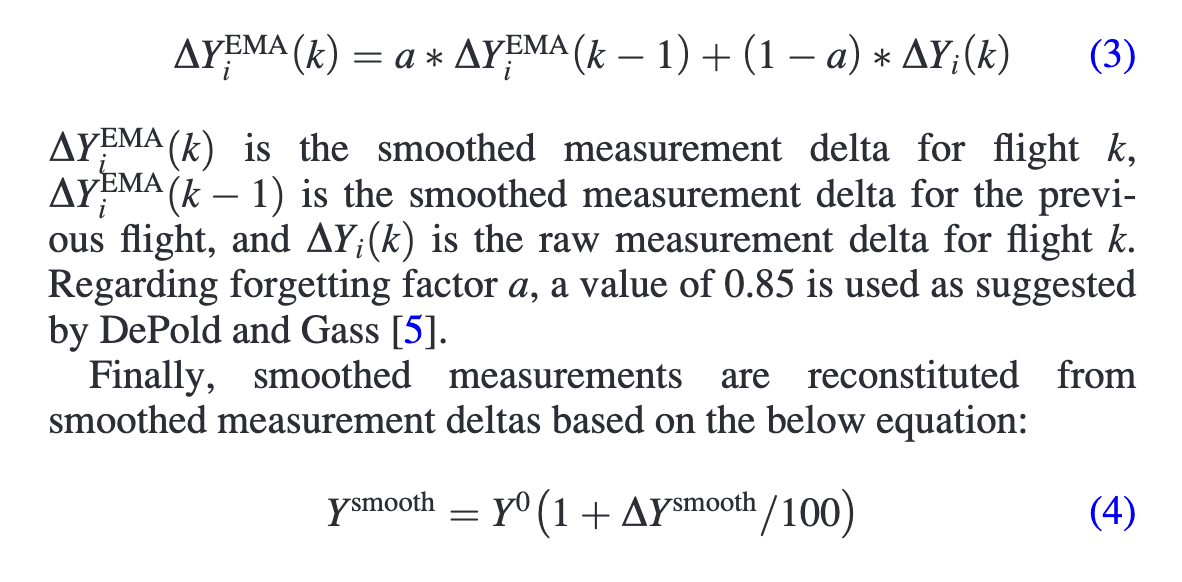

In [89]:
#implement exponential moving average to smooth data
alpha = 0.85 #prodimes user guide uses 0.8844
def apply_exponential_moving_average(df, alpha, deviation_columns):
  ema_data = df[['engine', 'flight']].copy()

  for column in deviation_columns:
      if column not in df.columns:
          raise KeyError(f"Column '{column}' not found in the DataFrame!")

      ema_values = []

      for engine_id in df['engine'].unique():

          engine_data = df[df['engine'] == engine_id]

          if engine_data.empty:
              print(f"Warning: No data found for engine {engine_id}.")
              continue

          ema = engine_data[column].iloc[0]
          ema_values_engine = [ema]

          for k in range(1, len(engine_data)):
              delta_y = engine_data[column].iloc[k]
              ema = alpha * ema + (1 - alpha) * delta_y
              ema_values_engine.append(ema)

          ema_values.extend(ema_values_engine)

      ema_data[f'{column}_ema'] = ema_values

  return ema_data

deviation_columns_to = final_deviation_to_df.drop(columns=['engine', 'flight']).columns

deviation_columns_c = final_deviation_c_df.drop(columns=['engine', 'flight']).columns

ema_health_y_to_df = apply_exponential_moving_average(final_deviation_to_df, alpha, deviation_columns_to)
ema_health_y_c_df = apply_exponential_moving_average(final_deviation_c_df, alpha, deviation_columns_c)

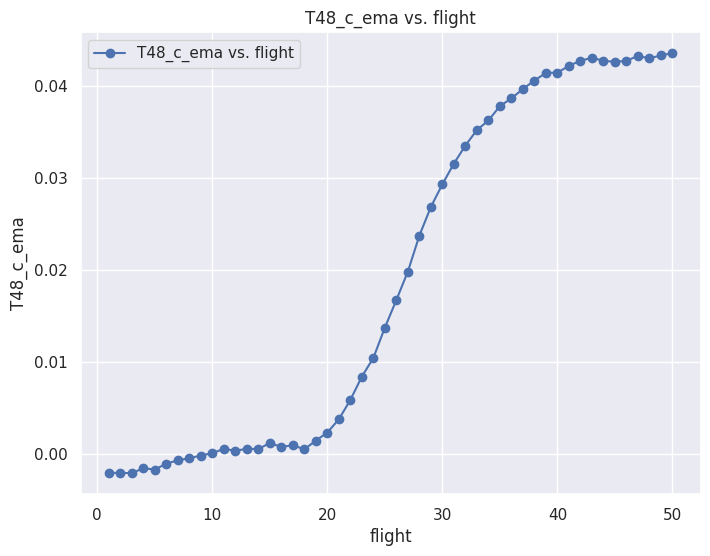

In [90]:
visualize_param(ema_health_y_c_df,442,"T48_c_ema","flight")

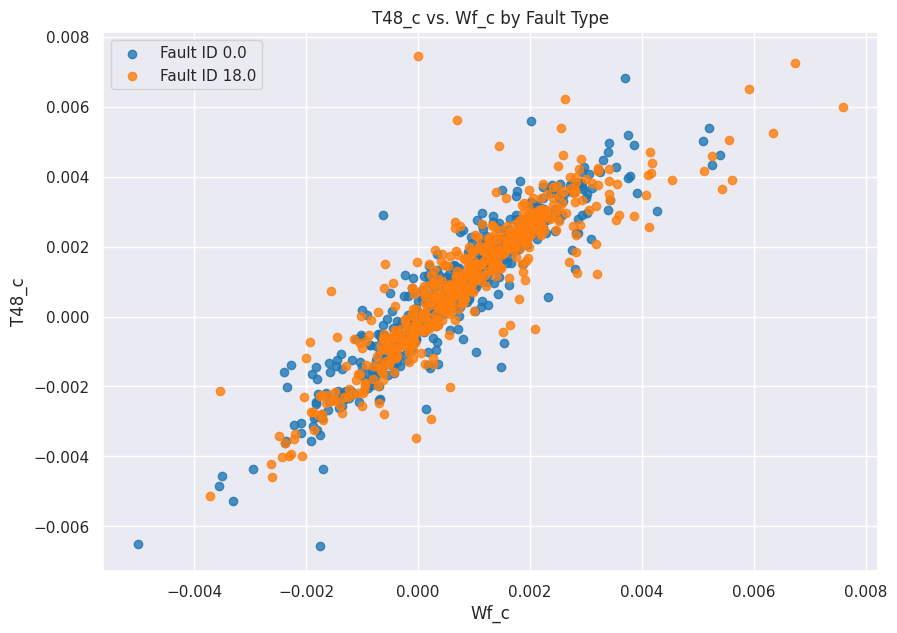

In [ ]:
faults = [0,18]
engines = fault_params_df[fault_params_df["fault_id"].isin(faults)].index

scatter_values(final_deviation_c_df.query('flight > 45'),engines,"T48_c","Wf_c",fault_params_df)

## Fault Identification & Classification

###Training and validation data treatment

In [ ]:
#testing without take off data
#data_total = pd.merge(ema_health_y_to_df, ema_health_y_c_df, on=['engine', 'flight'])
data_total = ema_health_y_c_df

In [ ]:
data_total.head()

,engine,flight,Nf_c_ema,Nc_c_ema,P24_c_ema,Ps30_c_ema,T24_c_ema,T30_c_ema,T48_c_ema,Wf_c_ema,P2_c_ema,T2_c_ema,Pamb_c_ema
0,1.0,1.0,-0.001187,-0.000926,-0.000466,-0.000446,-0.002005,-0.001777,-0.001468,-0.000773,-0.000279,-0.001904,-0.000019
1,1.0,2.0,-0.001135,-0.000847,-0.000397,-0.000485,-0.001886,-0.001610,-0.001343,-0.000831,-0.000267,-0.001800,-0.000025
2,1.0,3.0,-0.000985,-0.000756,-0.000303,-0.000439,-0.001643,-0.001406,-0.001152,-0.000707,-0.000220,-0.001588,-0.000020
3,1.0,4.0,-0.000895,-0.000663,-0.000299,-0.000358,-0.001441,-0.001287,-0.001107,-0.000703,-0.000187,-0.001374,-0.000014
4,1.0,5.0,-0.000727,-0.000554,-0.000225,-0.000291,-0.001204,-0.001067,-0.000870,-0.000508,-0.000146,-0.001162,-0.000009


In [ ]:
def createlabel(df,fault_param):
  label = {}
  for engine in df['engine'].unique():
    if engine not in fault_param.index:
      print(f"Warning: Engine {engine} not found in fault_param. Skipping.")
      continue  # Skip engines that are not in fault_param
    flight_init = fault_param.loc[engine]['fligh_initiation']
    fault_id = fault_param.loc[engine]['fault_id']

    for flight in df[df['engine'] == engine]['flight']:
      if flight < flight_init:
        label[(engine,flight)] = 0
      else:
        label[(engine,flight)] = fault_id
  return label


In [ ]:
fault_label = createlabel(data_total,fault_params_df)

In [ ]:
fault_label_df = (
    pd.DataFrame.from_dict(fault_label, orient='index', columns=['fault_label'])
    .reset_index()
)
fault_label_df[['engine', 'flight']] = pd.DataFrame(fault_label_df['index'].tolist(), index=fault_label_df.index)
fault_label_df = fault_label_df.drop(columns=['index'])

data_total_with_labels = pd.merge(data_total, fault_label_df, on=['engine', 'flight'], how='left')

In [ ]:
data_total_with_labels.head()

,engine,flight,Nf_c_ema,Nc_c_ema,P24_c_ema,Ps30_c_ema,T24_c_ema,T30_c_ema,T48_c_ema,Wf_c_ema,P2_c_ema,T2_c_ema,Pamb_c_ema,fault_label
0,1.0,1.0,-0.001187,-0.000926,-0.000466,-0.000446,-0.002005,-0.001777,-0.001468,-0.000773,-0.000279,-0.001904,-0.000019,0.0
1,1.0,2.0,-0.001135,-0.000847,-0.000397,-0.000485,-0.001886,-0.001610,-0.001343,-0.000831,-0.000267,-0.001800,-0.000025,0.0
2,1.0,3.0,-0.000985,-0.000756,-0.000303,-0.000439,-0.001643,-0.001406,-0.001152,-0.000707,-0.000220,-0.001588,-0.000020,0.0
3,1.0,4.0,-0.000895,-0.000663,-0.000299,-0.000358,-0.001441,-0.001287,-0.001107,-0.000703,-0.000187,-0.001374,-0.000014,0.0
4,1.0,5.0,-0.000727,-0.000554,-0.000225,-0.000291,-0.001204,-0.001067,-0.000870,-0.000508,-0.000146,-0.001162,-0.000009,0.0


In [ ]:
data_total_with_labels = data_total_with_labels.dropna(subset=['fault_label'])

In [ ]:
X = data_total_with_labels.drop(columns=['engine', 'flight', 'fault_label'])
y = data_total_with_labels['fault_label']

#in the future it will be better to make a subset of full flights for each engine for all fault scenarios

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

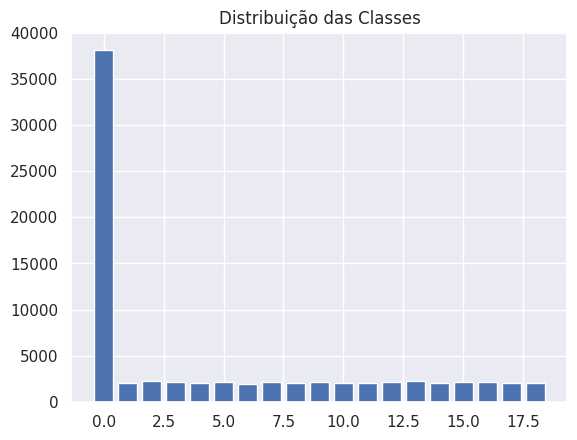

In [ ]:
plt.bar(np.unique(y_train), np.bincount(y_train))
plt.title('Distribuição das Classes')
plt.show()

In [ ]:
print('X_train shape : ',X_train.shape)
print('X_test shape : ',X_test.shape)
print('y_train shape : ',y_train.shape)
print('y_test shape : ',y_test.shape)

X_train shape :  (75800, 11)
X_test shape :  (18950, 11)
y_train shape :  (75800,)
y_test shape :  (18950,)


In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Classification Algorithms

In [ ]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler

num_classes = len(y_train.unique())
if num_classes > 2:  # Multiclass classification
    y_train_encoded = to_categorical(y_train, num_classes=num_classes)
    y_test_encoded = to_categorical(y_test, num_classes=num_classes)
else:
    y_train_encoded = y_train
    y_test_encoded = y_test

# Define the neural network
model_ANN = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax' if num_classes > 2 else 'sigmoid')  # Output layer
])

# Compile the model
model_ANN.compile(
    optimizer='adam',
    loss='categorical_crossentropy' if num_classes > 2 else 'binary_crossentropy',
    metrics=['accuracy']
)

# Train the model
history = model_ANN.fit(
    X_train, y_train_encoded,
    epochs=15,  # Adjust epochs as needed
    batch_size=32,
    validation_data=(X_test, y_test_encoded),
    verbose=1
)

# Evaluate the model
test_loss, test_accuracy = model_ANN.evaluate(X_test, y_test_encoded, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2369/2369 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.6583 - loss: 1.4832 - val_accuracy: 0.7908 - val_loss: 0.8769
Epoch 2/15
2369/2369 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.7687 - loss: 0.9401 - val_accuracy: 0.8009 - val_loss: 0.8239
Epoch 3/15
2369/2369 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.7897 - loss: 0.8789 - val_accuracy: 0.8048 - val_loss: 0.8030
Epoch 4/15
2369/2369 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.7947 - loss: 0.8626 - val_accuracy: 0.8056 - val_loss: 0.7916
Epoch 5/15
2369/2369 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.7989 - loss: 0.8493 - val_accuracy: 0.8075 - val_loss: 0.7814
Epoch 6/15
2369/2369 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.8008 - loss: 0.8373 - val_accuracy: 0.8072 - val_loss: 0.7762
Epoch 7/15
2369/2369 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.8022 - loss: 0.8339 - val_accuracy: 0.8072 - val_loss: 0.7747
Epoch 8/15
2369/2369 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.8004 - loss: 0.8311 - val_accu

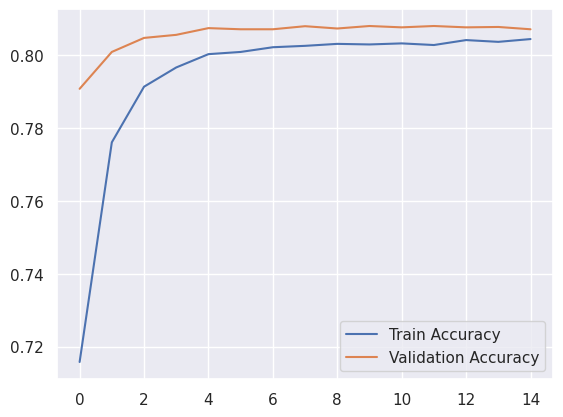

In [ ]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

593/593 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


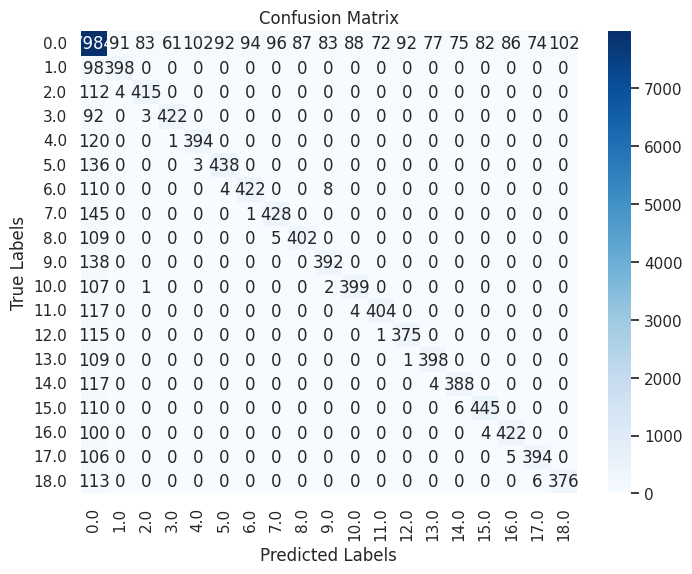

In [ ]:
y_pred = model_ANN.predict(X_test)

y_pred_labels = y_pred.argmax(axis=1)

cm = confusion_matrix(y_test, y_pred_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=y.unique(), yticklabels=y.unique())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from sklearn.preprocessing import StandardScaler

X_train_array = X_train
X_test_array = X_test

# Fazer o reshape
X_train_reshaped = X_train_array.reshape(X_train_array.shape[0], X_train_array.shape[1], 1)
X_test_reshaped = X_test_array.reshape(X_test_array.shape[0], X_test_array.shape[1], 1)

#one hot encode
y_train_encoded = tf.keras.utils.to_categorical(y_train, num_classes=num_classes)
y_test_encoded = tf.keras.utils.to_categorical(y_test, num_classes=num_classes)

# Define the CNN model
model_CNN = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train_reshaped.shape[1], 1)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    Conv1D(filters=128, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    Conv1D(filters=256, kernel_size=1, activation='relu'),
    BatchNormalization(),
    #MaxPooling1D(pool_size=2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model_CNN.compile(
    optimizer='adam',
    loss='categorical_crossentropy' if num_classes > 2 else 'binary_crossentropy',
    metrics=['accuracy']
)

# Train the model
history = model_CNN.fit(
    X_train_reshaped, y_train_encoded,
    epochs=30,  # Adjust epochs as needed
    batch_size=32,
    validation_data=(X_test_reshaped, y_test_encoded),
    verbose=1
)

# Evaluate the model
test_loss, test_accuracy = model_CNN.evaluate(X_test_reshaped, y_test_encoded, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2369/2369 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - accuracy: 0.7172 - loss: 1.2183 - val_accuracy: 0.7838 - val_loss: 0.8996
Epoch 2/30
2369/2369 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - accuracy: 0.7710 - loss: 0.9650 - val_accuracy: 0.7877 - val_loss: 0.8834
Epoch 3/30
2369/2369 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step - accuracy: 0.7746 - loss: 0.9338 - val_accuracy: 0.7872 - val_loss: 0.8639
Epoch 4/30
2369/2369 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step - accuracy: 0.7776 - loss: 0.9210 - val_accuracy: 0.7889 - val_loss: 0.8604
Epoch 5/30
2369/2369 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - accuracy: 0.7809 - loss: 0.8959 - val_accuracy: 0.7888 - val_loss: 0.8431
Epoch 6/30
2369/2369 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step - accuracy: 0.7803 - loss: 0.8974 - val_accuracy: 0.7906 - val_loss: 0.8408
Epoch 7/30
2369/2369 ━━━━━━━━━━━━━━━━━━━━ 22s 8ms/step - accuracy: 0.7838 - loss: 0.8819 - val_accuracy: 0.7905 - val_loss: 0.8339
Epoch 8/30
2369/2369 ━━━━━━━━━━━━━━━━━━━━ 22s 8ms/step - accuracy: 0.7795 - loss: 0.8875 - val

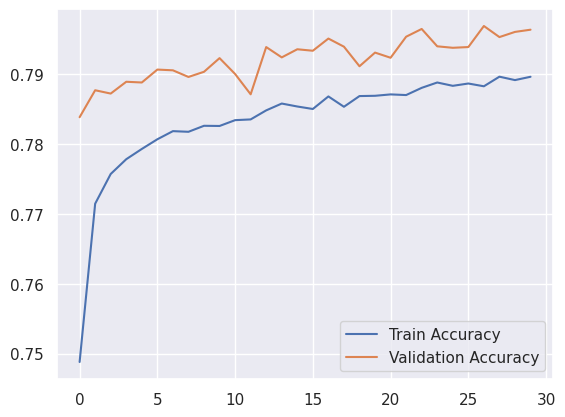

In [ ]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

593/593 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


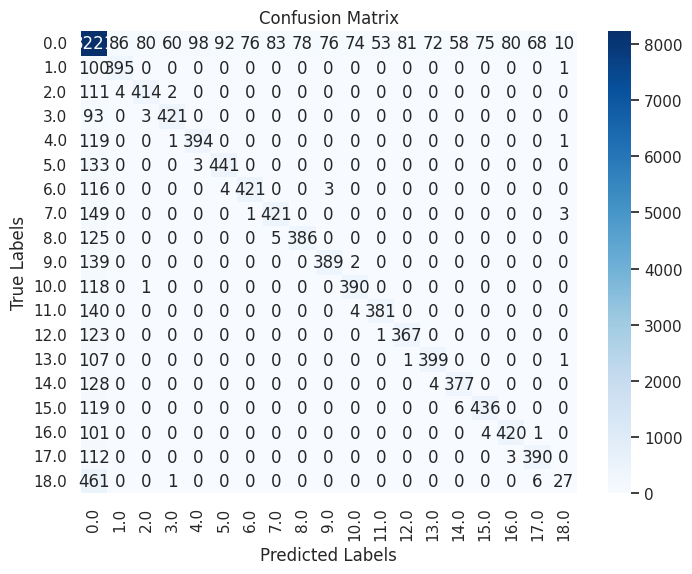

In [ ]:
y_pred = model_CNN.predict(X_test)

y_pred_labels = y_pred.argmax(axis=1)

cm = confusion_matrix(y_test, y_pred_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=y.unique(), yticklabels=y.unique())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
y_pred

array([[8.6456031e-02, 4.8531490e-09, 1.2037249e-07, ..., 1.4406673e-09,
        1.2928222e-10, 4.1686772e-07],
       [8.6782771e-01, 8.0498336e-03, 2.2585026e-03, ..., 8.7498706e-03,
        1.7916495e-03, 2.1051778e-02],
       [4.4117581e-02, 9.5081496e-08, 8.9788781e-09, ..., 3.9278407e-07,
        2.3366455e-08, 9.5508494e-07],
       ...,
       [6.8050838e-01, 1.0775675e-02, 6.2579964e-03, ..., 8.8534877e-03,
        6.7607663e-03, 6.8473414e-02],
       [7.7944916e-01, 4.6520554e-03, 7.0376778e-03, ..., 2.4738687e-03,
        4.5157499e-03, 4.2690191e-02],
       [1.3645685e-01, 4.8728812e-06, 2.6436493e-07, ..., 1.4406702e-07,
        2.2876922e-08, 2.4660317e-06]], dtype=float32)

## Testing with new data for evaluation

In [ ]:
filename = 'data_evaluation.mat'

location = "/content/drive/MyDrive/Mestrado/Condition Based HM/ProDiMES/"

file_path = location + filename

data_eval = loadmat(file_path)

efs_output_c_eval = data_eval['efs_output_c']
efs_output_to_eval = data_eval['efs_output_to']
engine_params_eval = data_eval['engine_params']
fault_params_eval = data_eval['fault_params']
sensor_noise_eval = data_eval['sensor_noise']

engines, flights, variables = efs_output_c_eval.shape

efs_output_c_flat_eval = efs_output_c_eval.reshape(engines * flights, variables)

engine_ids_eval = np.repeat(np.arange(1, engines + 1), flights)
flight_ids_eval = np.tile(np.arange(1, flights + 1), engines)

column_names = ["engine", "flight"] + ["Nf_c","Nc_c","P24_c","Ps30_c","T24_c","T30_c","T48_c","Wf_c","P2_c","T2_c","Pamb_c"]
data_eval = np.column_stack((engine_ids_eval, flight_ids_eval, efs_output_c_flat_eval))
efs_output_c_df_eval = pd.DataFrame(data_eval, columns=column_names)

In [ ]:
engines, flights, variables = efs_output_to_eval.shape

efs_output_to_flat_eval = efs_output_to_eval.reshape(engines * flights, variables)

engine_ids_eval = np.repeat(np.arange(1, engines + 1), flights)
flight_ids_eval = np.tile(np.arange(1, flights + 1), engines)

column_names = ["engine", "flight"] + ["Nf_to","Nc_to","P24_to","Ps30_to","T24_to","T30_to","T48_to","Wf_to","P2_to","T2_to","Pamb_to"]
data = np.column_stack((engine_ids_eval, flight_ids_eval, efs_output_to_flat_eval))
efs_output_to_df_eval = pd.DataFrame(data_eval, columns=column_names)

In [ ]:
engines, flights, params = engine_params_eval.shape

engine_params_flat_eval = engine_params_eval.reshape(engines * flights, params)

engine_params_columns = ["engine", "flight","altitude_to","mach_to","dTamb_to","NfR_to","altitude_c","mach_c",
                         "dTamb_c","Fn_c","fan_eff","fan_fc","lpc_eff","lpc_fc","hpc_eff","hpc_fc",
                         "hpt_eff","hpt_fc","lpt_eff","lpt_fc"]

engine_ids_eval = np.repeat(np.arange(1, engines + 1), flights)
flight_ids_eval = np.tile(np.arange(1, flights + 1), engines)

data_eval = np.column_stack((engine_ids_eval, flight_ids_eval, engine_params_flat_eval))
engine_params_df_eval = pd.DataFrame(data_eval, columns=engine_params_columns)

In [ ]:
fault_params_df_eval = pd.DataFrame(fault_params_eval, columns=["fault_id","fligh_initiation","fault_ev_rate","fault_magnitude","fc_eff_ratio"])

In [ ]:
fault_params_df_eval = fault_params_df_eval.rename_axis("engine")

In [ ]:
u_orig_to_eval = engine_params_df_eval[["altitude_to","mach_to","dTamb_to","NfR_to"]]
u_orig_c_eval = engine_params_df_eval[["altitude_c","mach_c","dTamb_c","Fn_c"]]

health_y_to_eval = {}
for column, model_health in models_to.items():
    health_y_to_eval[column] = model_health.predict(u_orig_to_eval)

health_y_c_eval = {}
for column, model_health in models_c.items():
    health_y_c_eval[column] = model_health.predict(u_orig_c_eval)

health_y_to_df_eval = pd.DataFrame(health_y_to_eval)
health_y_c_df_eval = pd.DataFrame(health_y_c_eval)

In [ ]:
deviation_to_eval = {}
for column in efs_output_to_df_eval.columns[2:]:
  deviation_to_eval[column] = (efs_output_to_df_eval[column] - health_y_to_df_eval[column])/health_y_to_df_eval[column]

deviation_c_eval = {}
for column in efs_output_c_df_eval.columns[2:]:
  deviation_c_eval[column] = (efs_output_c_df_eval[column] - health_y_c_df_eval[column])/health_y_c_df_eval[column]


deviation_to_df_eval = pd.DataFrame(deviation_to_eval)
deviation_c_df_eval = pd.DataFrame(deviation_c_eval)

In [ ]:
deviation_c_df_eval["engine"] = efs_output_c_df_eval["engine"]
deviation_c_df_eval["flight"] = efs_output_c_df_eval["flight"]

deviation_to_df_eval["engine"] = efs_output_to_df_eval["engine"]
deviation_to_df_eval["flight"] = efs_output_to_df_eval["flight"]

In [ ]:
average_deviation_to_df_eval = calculate_average_deviation(deviation_to_df_eval)
average_deviation_c_df_eval = calculate_average_deviation(deviation_c_df_eval)

<ipython-input-35-e4d2687681d1>:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda group: group.iloc[:10, :-2].mean())
<ipython-input-35-e4d2687681d1>:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda group: group.iloc[:10, :-2].mean())


In [ ]:
health_y_c_df_eval["flight"] = efs_output_c_df_eval["flight"]
health_y_c_df_eval["engine"] = efs_output_c_df_eval["engine"]

health_y_to_df_eval["flight"] = efs_output_to_df_eval["flight"]
health_y_to_df_eval["engine"] = efs_output_to_df_eval["engine"]

In [ ]:
updated_health_y_to_df_eval = update_health_conditions(health_y_to_df_eval, average_deviation_to_df_eval, health_y_to_df_eval.drop(columns=["engine","flight"]).columns)
updated_health_y_c_df_eval = update_health_conditions(health_y_c_df_eval, average_deviation_c_df_eval, health_y_c_df_eval.drop(columns=["engine","flight"]).columns)

In [ ]:
final_deviation_to_df_eval = calculate_final_deviations(efs_output_to_df_eval, updated_health_y_to_df_eval, health_y_to_df_eval.drop(columns=["engine","flight"]).columns)
final_deviation_c_df_eval = calculate_final_deviations(efs_output_c_df_eval, updated_health_y_c_df_eval, health_y_c_df_eval.drop(columns=["engine","flight"]).columns)

In [ ]:
final_deviation_to_df_eval["engine"] = efs_output_to_df_eval["engine"]
final_deviation_to_df_eval["flight"] = efs_output_to_df_eval["flight"]

final_deviation_c_df_eval["engine"] = efs_output_c_df_eval["engine"]
final_deviation_c_df_eval["flight"] = efs_output_c_df_eval["flight"]

In [ ]:
deviation_columns_to_eval = final_deviation_to_df_eval.drop(columns=['engine', 'flight']).columns

deviation_columns_c_eval = final_deviation_c_df_eval.drop(columns=['engine', 'flight']).columns

ema_health_y_to_df_eval = apply_exponential_moving_average(final_deviation_to_df_eval, alpha, deviation_columns_to_eval)
ema_health_y_c_df_eval = apply_exponential_moving_average(final_deviation_c_df_eval, alpha, deviation_columns_c_eval)

In [ ]:
#data_total_eval = pd.merge(ema_health_y_to_df_eval, ema_health_y_c_df_eval, on=['engine', 'flight'])
data_total_eval = ema_health_y_c_df_eval

In [ ]:
fault_label_eval = createlabel(data_total_eval,fault_params_df_eval)

In [ ]:
fault_label_df_eval = (
    pd.DataFrame.from_dict(fault_label_eval, orient='index', columns=['fault_label'])
    .reset_index()
)
fault_label_df_eval[['engine', 'flight']] = pd.DataFrame(fault_label_df_eval['index'].tolist(), index=fault_label_df_eval.index)
fault_label_df_eval = fault_label_df_eval.drop(columns=['index'])

data_total_with_labels_eval = pd.merge(data_total_eval, fault_label_df_eval, on=['engine', 'flight'], how='left')

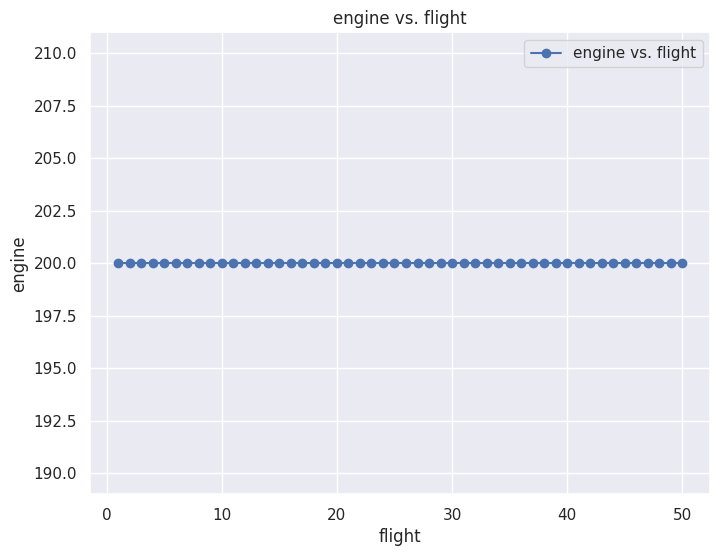

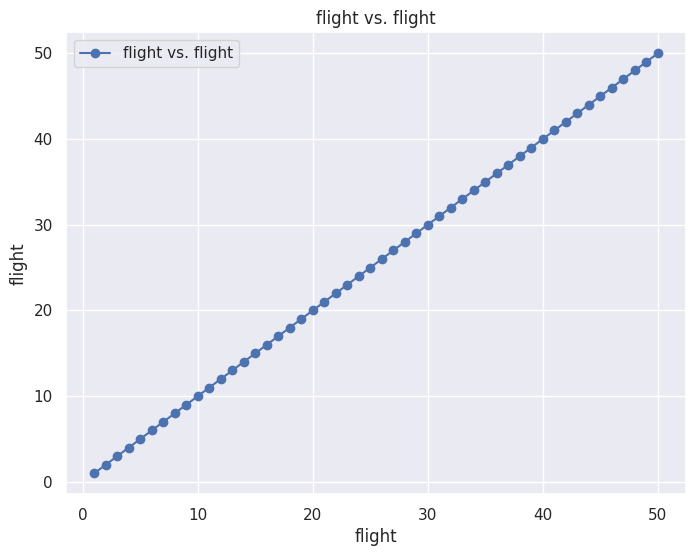

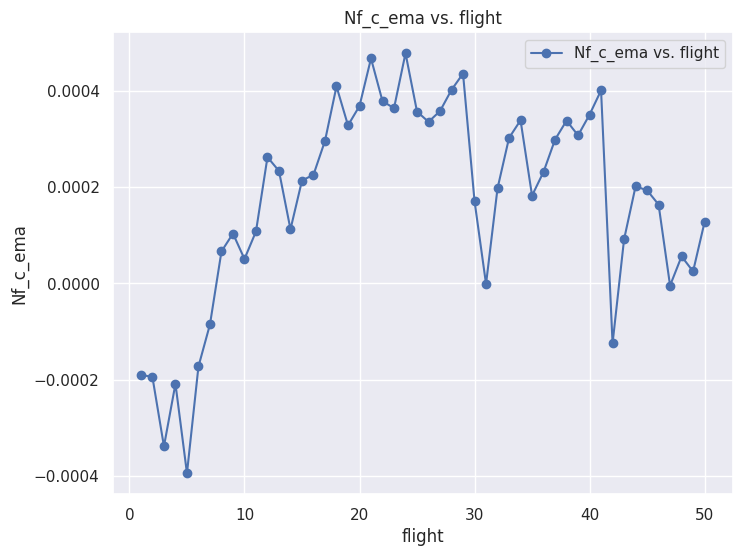

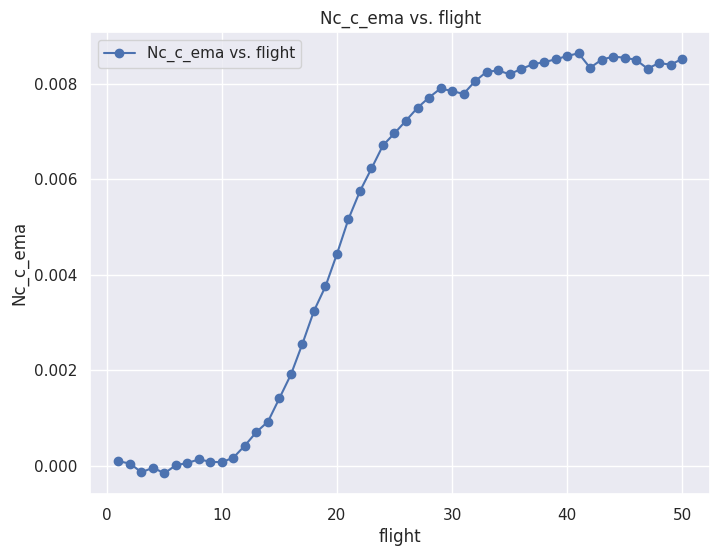

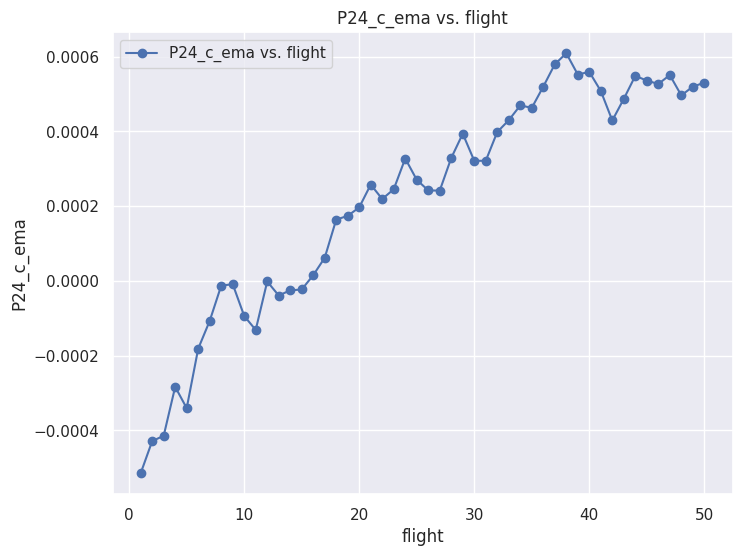

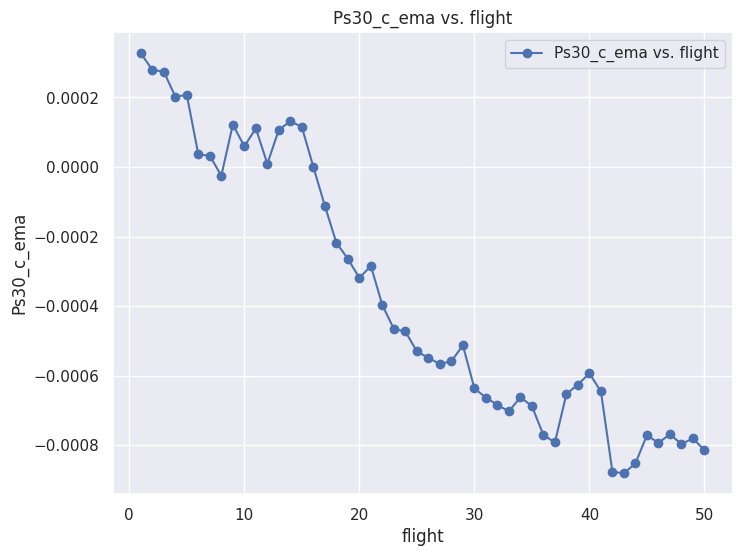

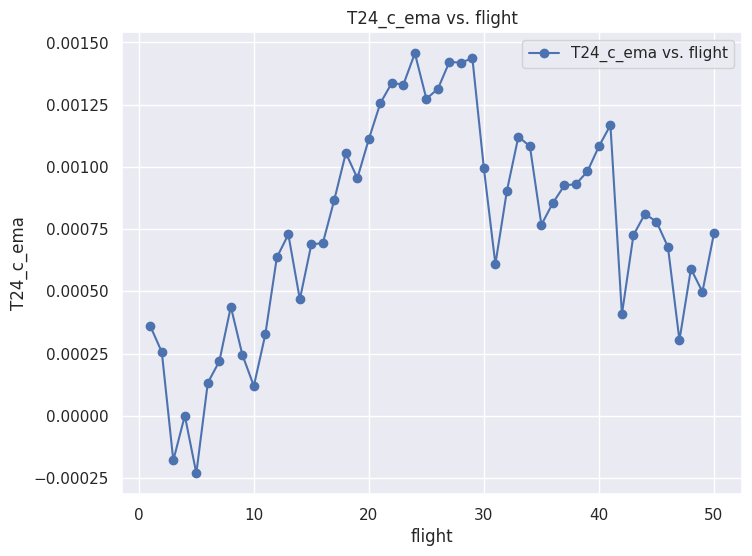

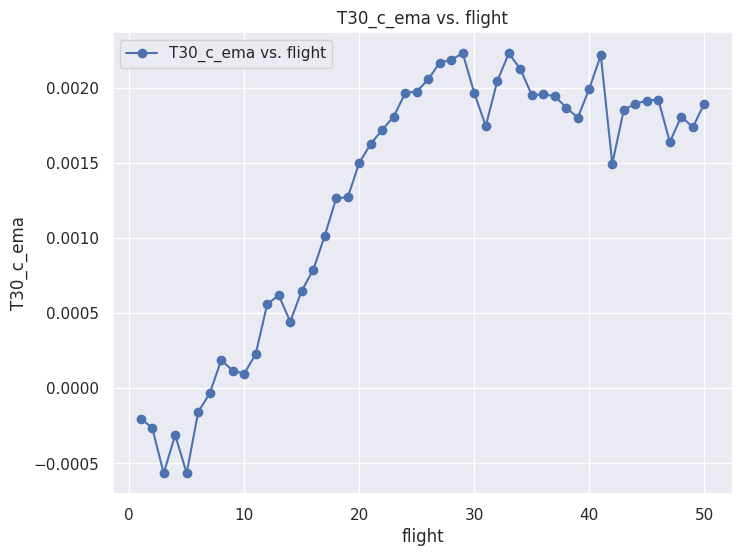

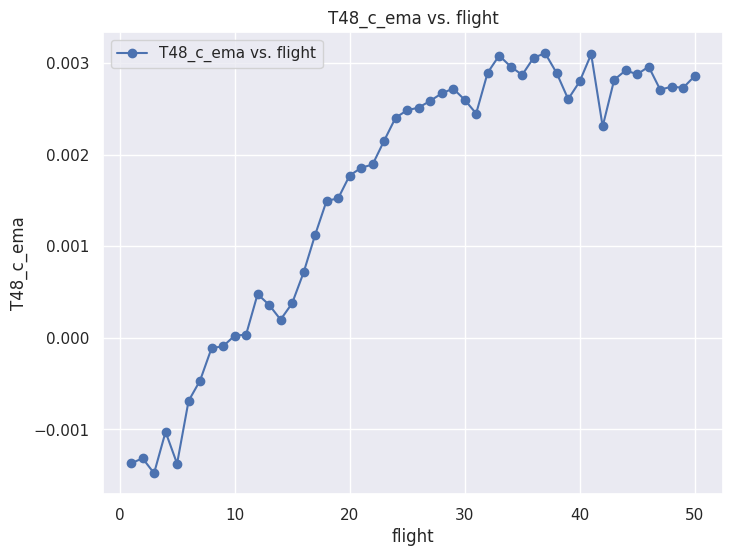

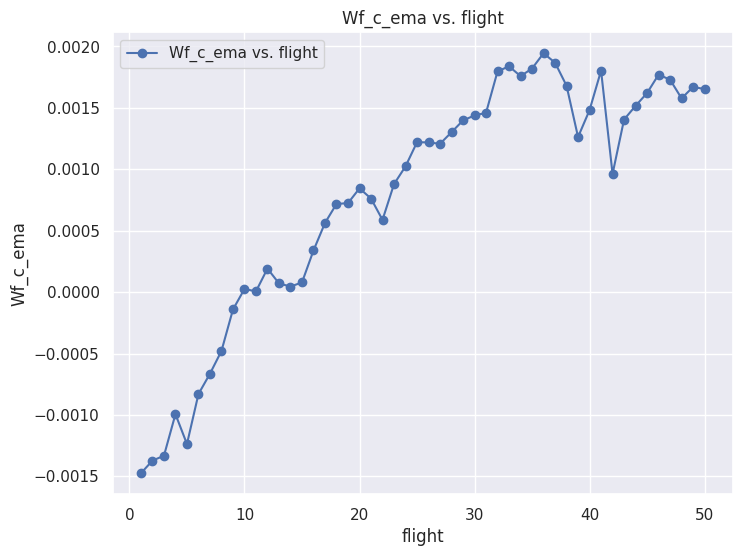

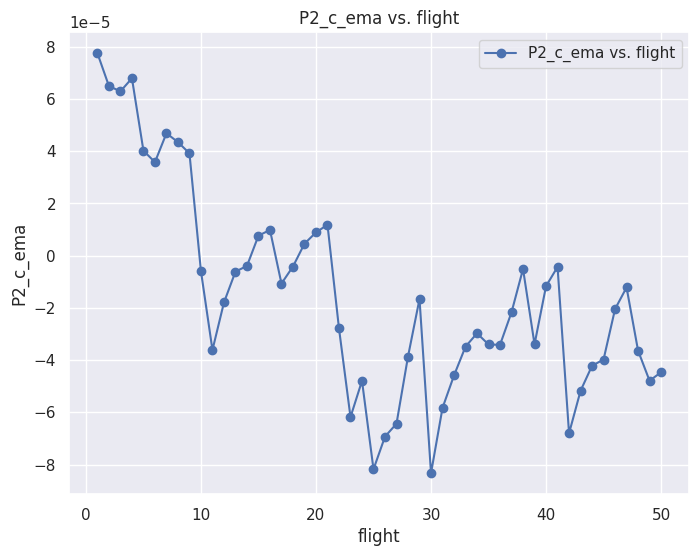

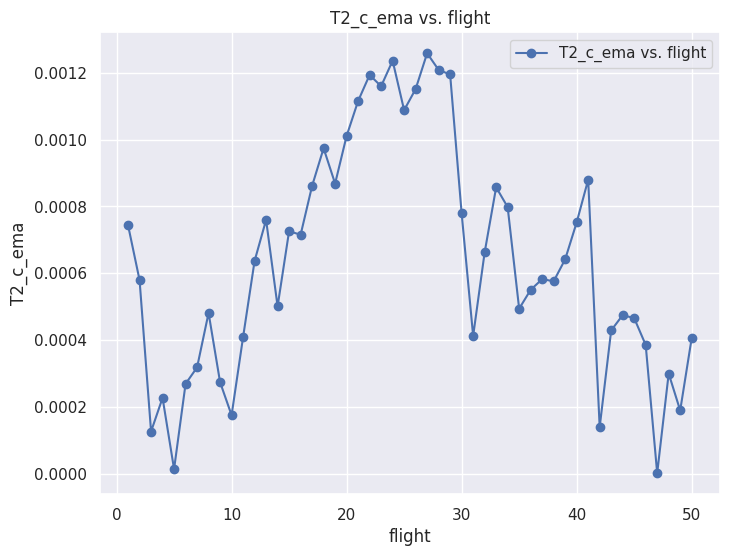

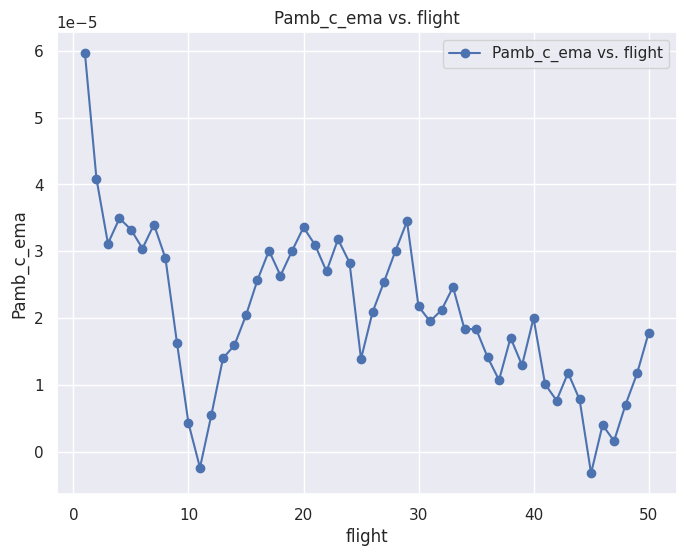

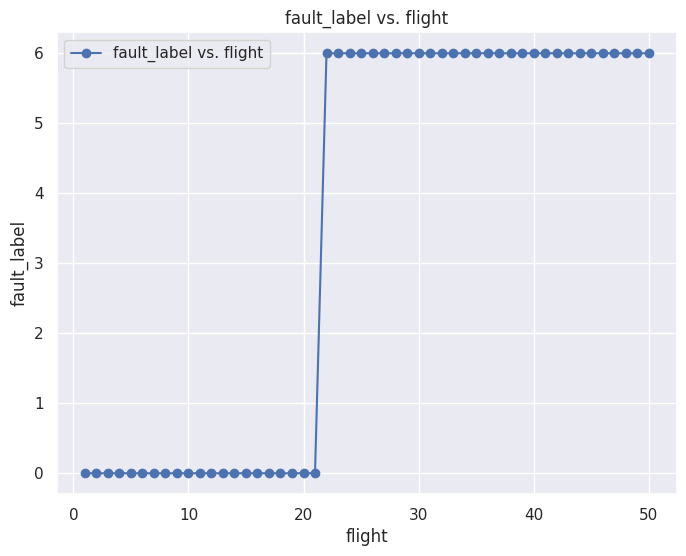

In [ ]:
for column in data_total_with_labels_eval:
  visualize_param(data_total_with_labels_eval,200,column,"flight")

In [ ]:
data_total_with_labels_eval = data_total_with_labels_eval.dropna(subset=['fault_label'])

In [ ]:
X_eval = data_total_with_labels_eval.drop(columns=['engine', 'flight', 'fault_label'])
y_eval = data_total_with_labels_eval['fault_label']

In [ ]:
#X_eval_array = X_eval.values
X_eval = scaler.transform(X_eval)
#X_eval_reshaped = X_eval_array.reshape(X_eval_array.shape[0], X_eval_array.shape[1], 1)

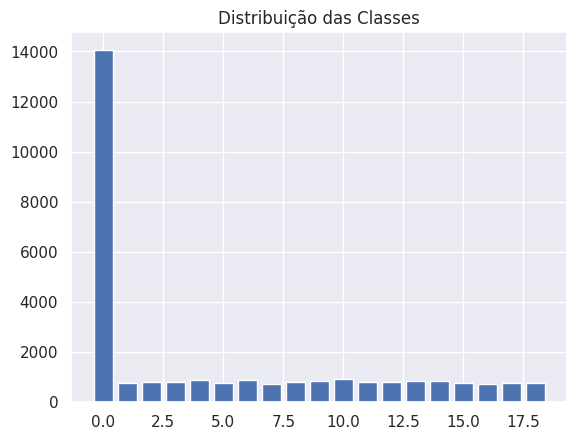

In [ ]:
plt.bar(np.unique(y_eval), np.bincount(y_eval))
plt.title('Distribuição das Classes')
plt.show()

888/888 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


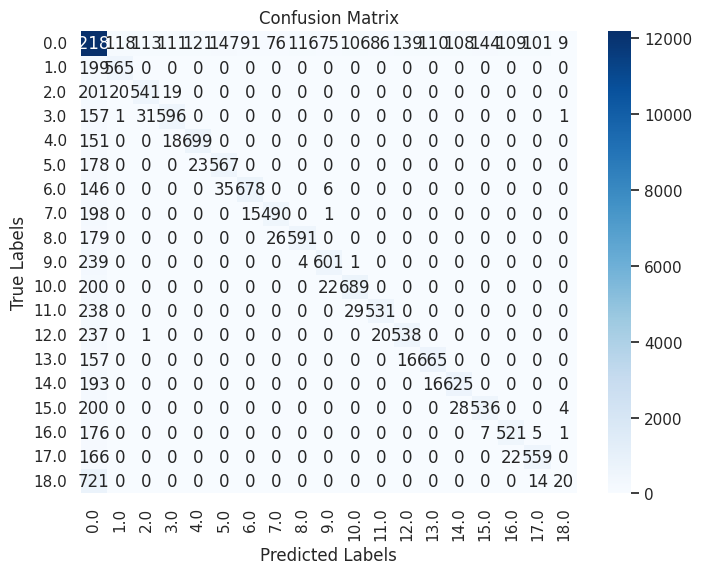

In [ ]:
y_pred_eval = model_CNN.predict(X_eval)

y_pred_labels_eval = y_pred_eval.argmax(axis=1)

cm = confusion_matrix(y_eval, y_pred_labels_eval)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=y.unique(), yticklabels=y.unique())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

### Diagnostic Matrix

In [ ]:
def create_diagnostic_matrix(engines, flights, y_predicted):
    engines = engines.astype(int)
    flights = flights.astype(int)

    num_engines = len(set(engines))
    num_flights = flights.max()

    y_pred_labels = np.argmax(y_predicted, axis=1)

    diagnostic_matrix = diagnostic_matrix = y_pred_labels.reshape(num_engines, num_flights)

    return diagnostic_matrix

In [ ]:
diagnostic_matrix = create_diagnostic_matrix(
    data_total_with_labels_eval["engine"],
    data_total_with_labels_eval["flight"],
    y_pred_eval
)

In [ ]:
diagnostic_matrix[360]

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
       12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12])

In [ ]:
from scipy.io import savemat

# Data to save
data_to_save = {'diagnostic_matrix': diagnostic_matrix}

# Save to .mat file
savemat('diagnostic_matrix.mat', data_to_save)

print("Diagnostic matrix saved to diagnostic_matrix.mat")

Diagnostic matrix saved to diagnostic_matrix.mat


## Evaluation

In [ ]:
from sklearn.metrics import confusion_matrix, cohen_kappa_score


diagnostic_assessment = diagnostic_matrix


num_engines, _ = fault_params_df_eval.shape
num_assessments, num_flights = diagnostic_assessment.shape  # Number of flights per engine

if num_assessments != num_engines:
    print("Number of engines does not equal number of assessments!!!")

print("Evaluating Results")

# Fault magnitude thresholds (small, lmedium, large)
sml_fault_mag = np.array([
    [3, 5],   # Fan (%)
    [3, 5],   # LPC (%)
    [3, 5],   # HPC (%)
    [3, 5],   # HPT (%)
    [3, 5],   # LPT (%)
    [3, 5],   # VSV (%)
    [7, 13],  # VBV (%)
    [4, 7],   # Nf (sigma)
    [4, 7],   # Nc (sigma)
    [4, 7],   # P24 (sigma)
    [4, 7],   # Ps30 (sigma)
    [4, 7],   # T24 (sigma)
    [4, 7],   # T30 (sigma)
    [4, 7],   # T48 (sigma)
    [4, 7],   # Wf36 (sigma)
    [4, 7],   # P2 (sigma)
    [4, 7],   # T2 (sigma)
    [7, 13]   # Pamb (sigma)
])

# Parameters
start_flight = 11
abrupt_window = 10
rapid_window = 6

# Initialize confusion matrices and counters
confusion_matrix = np.zeros((18, 19, 2, 3)) # True condition x Diagnosed condition x Evolution x Magnitude
confusion_matrix_nf = np.zeros((1, 19)) # For "No Fault" cases

tp_latency = np.zeros((18, 2, 3))
cc_latency = np.zeros((18, 2, 3))
tp_counter = np.zeros((18, 2, 3))
cc_counter = np.zeros((18, 2, 3))

# Ensure num_engines is correctly aligned with diagnostic_assessment
num_engines = diagnostic_assessment.shape[0]  # Match the first dimension of diagnostic_assessment

for i1 in range(num_engines):  # Iterate over valid engine indices
    true_fault_type = int(fault_params_df_eval.iloc[i1, 0])
    start_fault_flight = int(fault_params_df_eval.iloc[i1, 1])
    fault_rate = int(fault_params_df_eval.iloc[i1, 2])
    fault_magnitude = abs(fault_params_df_eval.iloc[i1, 3])

    # 1. No Fault cases
    if true_fault_type == 0:
        for i2 in range(start_flight, num_flights):
          diagnosed_condition = diagnostic_assessment[i1, i2]
          column = 19 if diagnosed_condition == 0 else diagnosed_condition
          confusion_matrix_nf[0, column - 1] += 1


    # 2. Fault cases
    else:
      FP_flag = False #false positive flag
      TP_flag = False #true positive flag
      CC_flag = False #correct classification flag

      if fault_rate == 0:  # Abrupt
          evol_flag = 0
          diagnostic_window = range(start_fault_flight, start_fault_flight + abrupt_window)
      else:  # Rapid
          evol_flag = 1
          diagnostic_window = range(start_fault_flight, start_fault_flight + fault_rate + rapid_window)

      if fault_magnitude < sml_fault_mag[true_fault_type - 1, 0]:
          mag_flag = 0  # Small
      elif fault_magnitude > sml_fault_mag[true_fault_type - 1, 1]:
          mag_flag = 2  # Large
      else:
          mag_flag = 1  # Medium

      for i2 in range(start_flight, start_fault_flight):
          diagnosed_condition = diagnostic_assessment[i1, i2]
          column = 19 if diagnosed_condition == 0 else diagnosed_condition
          confusion_matrix_nf[0, column - 1] += 1
          if diagnosed_condition != 0:
                FP_flag = True
          for i2 in diagnostic_window:
            if i2 >= num_flights:
                break
            diagnosed_condition = diagnostic_assessment[i1, i2]
            column = 19 if diagnosed_condition == 0 else diagnosed_condition
            confusion_matrix[true_fault_type - 1, column - 1, evol_flag, mag_flag] += 1

            if not TP_flag and not FP_flag:
                tp_counter[true_fault_type - 1, evol_flag, mag_flag] += 1
                tp_latency[true_fault_type - 1, evol_flag, mag_flag] += i2 - start_fault_flight
                TP_flag = True

            if diagnosed_condition == true_fault_type and not CC_flag and not FP_flag:
                cc_counter[true_fault_type - 1, evol_flag, mag_flag] += 1
                cc_latency[true_fault_type - 1, evol_flag, mag_flag] += i2 - start_fault_flight
                CC_flag = True

confusion_matrix_abrupt = np.sum(confusion_matrix[:, :, 0, :], axis=2)
confusion_matrix_abrupt = np.vstack([confusion_matrix_abrupt, confusion_matrix_nf])

confusion_matrix_rapid = np.sum(confusion_matrix[:, :, 1, :], axis=2)
confusion_matrix_rapid = np.vstack([confusion_matrix_rapid, confusion_matrix_nf])

# --- Create small, medium, and large confusion matrices ---
confusion_matrix_abrupt_small = np.vstack([confusion_matrix[:, :, 0, 0], confusion_matrix_nf])
confusion_matrix_abrupt_medium = np.vstack([confusion_matrix[:, :, 0, 1], confusion_matrix_nf])
confusion_matrix_abrupt_large = np.vstack([confusion_matrix[:, :, 0, 2], confusion_matrix_nf])

confusion_matrix_rapid_small = np.vstack([confusion_matrix[:, :, 1, 0], confusion_matrix_nf])
confusion_matrix_rapid_medium = np.vstack([confusion_matrix[:, :, 1, 1], confusion_matrix_nf])
confusion_matrix_rapid_large = np.vstack([confusion_matrix[:, :, 1, 2], confusion_matrix_nf])

def create_decision_matrix(conf_matrix):
    tp_fp = np.sum(conf_matrix[:18, :18])  # True Positives + False Positives
    fn = np.sum(conf_matrix[18, :18])      # False Negatives
    tn = conf_matrix[18, 18]               # True Negatives

    return np.array([[tp_fp, np.sum(conf_matrix[:18, 18])], [fn, tn]])

# --- Create decision matrices for abrupt and rapid cases ---
decision_matrix_abrupt = create_decision_matrix(confusion_matrix_abrupt)
decision_matrix_rapid = create_decision_matrix(confusion_matrix_rapid)

# --- Create decision matrices for small, medium, and large cases ---
decision_matrix_abrupt_small = create_decision_matrix(confusion_matrix_abrupt_small)
decision_matrix_abrupt_medium = create_decision_matrix(confusion_matrix_abrupt_medium)
decision_matrix_abrupt_large = create_decision_matrix(confusion_matrix_abrupt_large)

decision_matrix_rapid_small = create_decision_matrix(confusion_matrix_rapid_small)
decision_matrix_rapid_medium = create_decision_matrix(confusion_matrix_rapid_medium)
decision_matrix_rapid_large = create_decision_matrix(confusion_matrix_rapid_large)

# Kappa Coefficients
def calculate_kappa_coefficient(confusion_matrix):
    observed_agreement = np.trace(confusion_matrix)  # Sum of diagonal elements
    total = np.sum(confusion_matrix)  # Total number of observations
    expected_agreement = 0

    for i in range(confusion_matrix.shape[0]):
        row_sum = np.sum(confusion_matrix[i, :]) / total
        col_sum = np.sum(confusion_matrix[:, i]) / total
        expected_agreement += row_sum * col_sum

    kappa_coefficient = (observed_agreement - expected_agreement * total) / (total - expected_agreement * total)
    return kappa_coefficient

# Calculate Kappa coefficients for each confusion matrix
KappaCoefficient_abrupt = calculate_kappa_coefficient(confusion_matrix_abrupt)
KappaCoefficient_rapid = calculate_kappa_coefficient(confusion_matrix_rapid)
KappaCoefficient_abrupt_small = calculate_kappa_coefficient(confusion_matrix_abrupt_small)
KappaCoefficient_abrupt_medium = calculate_kappa_coefficient(confusion_matrix_abrupt_medium)
KappaCoefficient_abrupt_large = calculate_kappa_coefficient(confusion_matrix_abrupt_large)
KappaCoefficient_rapid_small = calculate_kappa_coefficient(confusion_matrix_rapid_small)
KappaCoefficient_rapid_medium = calculate_kappa_coefficient(confusion_matrix_rapid_medium)
KappaCoefficient_rapid_large = calculate_kappa_coefficient(confusion_matrix_rapid_large)

Number of engines does not equal number of assessments!!!
Evaluating Results


In [ ]:
print("Kappa Coefficient Abrupt: ",KappaCoefficient_abrupt)
print("Kappa Coefficient Rapid: ", KappaCoefficient_rapid)
print("Kappa Coefficient Abrupt Small: ", KappaCoefficient_abrupt_small)
print("Kappa Coefficient Abrupt Medium: ", KappaCoefficient_abrupt_medium)
print("Kappa Coefficient Abrupt Large: ", KappaCoefficient_abrupt_large)
print("Kappa Coefficient Rapid Small: ", KappaCoefficient_rapid_small)
print("Kappa Coefficient Rapid Medium: ", KappaCoefficient_rapid_medium)
print("Kappa Coefficient Rapid Large: ", KappaCoefficient_rapid_large)

Kappa Coefficient Abrupt:  0.8945176864979578
Kappa Coefficient Rapid:  0.7881631617367476
Kappa Coefficient Abrupt Small:  0.8275489955608426
Kappa Coefficient Abrupt Medium:  0.9578864560497189
Kappa Coefficient Abrupt Large:  0.927726843383366
Kappa Coefficient Rapid Small:  0.695535176491047
Kappa Coefficient Rapid Medium:  0.8383689908622687
Kappa Coefficient Rapid Large:  0.893760650797866


In [ ]:
tp_latency_avg

0.0

In [ ]:
cc_latency_avg

0.30638297872340425